# 002 - DHCP

The goal of this demo is to make our little network feel more like what we're used to at home. Specifically, in the
last demo the "PCs" were manually given IP addresses. But for most of us at home, you would never do that. In fact,
you are likely rarely even aware of what your computer's actual address is.

You will see the following protocols in action:

* Dynamic Host Configuration Protocol (DHCP)

In [1]:
from routersim.topology import Topology
from simhelpers import topology_diagram
from simhelpers import frame_sequence,packet_sequence
from IPython.display import Image

The topology below will be nearly identical to what we did in 001, except that we won't assign
addresses to pc1 and pc2.

We will also add an additional server which we will use for "utility" servers, such as DHCP.

It's using the common /24 that most of our home networks do: 192.168.1.0/24

This comes a standard allocation in [RFC 1918](https://datatracker.ietf.org/doc/html/rfc1918) which specifies that
everything from 192.168.0.0 to 192.168.255.255 (192.168.0.0/16) would be for private usage and should never
be out on the public Internet. 10/8 (10.0.0.0 - 10.255.255.255) and 127.16/12 (172.16.0.0 - 172.17.255.255) are also
included in that allocation. So if you were wondering why those "prefixes" were so common when dealing with private
networks (corporate, VPN, etc), there you go!



In [2]:
homenetwork = Topology("My LAN")

switch = homenetwork.add_switch("sw1")
pc1 = homenetwork.add_server("pc1")
pc2 = homenetwork.add_server("pc2")


infra = homenetwork.add_server("utility", interface_addr="192.168.1.10/24")


switch.interface('et1').connect(pc1.main_interface)
switch.interface('et2').connect(pc2.main_interface)
switch.interface('et3').connect(infra.main_interface)


You *might* be wondering why in my demo about DHCP I had to give an address to one of the servers.

This is because otherwise we would be stuck because our DHCP server would need another DHCP server to get an IP,
which would be less than optimal!

Also note that in most home networks, the combined router + switch + Wifi AP will be used as the DHCP server. 
That could have been done here as well but I'm more interested in showing the individual components as they operate.


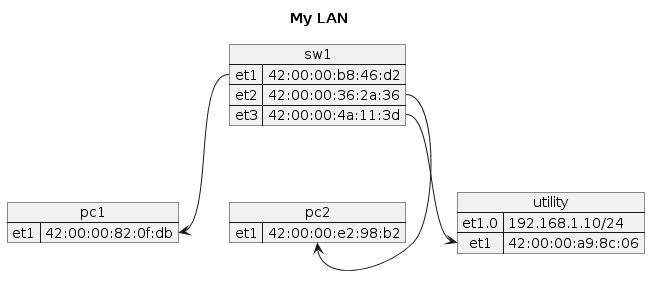

In [3]:
display(
    Image(
topology_diagram(homenetwork.name, homenetwork.get_topology()).png()
    )
)

Ok so you can see above that our two PCs do have network interfaces, but they have no IP address, whereas
our "utility" server has the `192.168.1.10` address we assigned to it. See below "A digression into bitmasks" if you want
to explore a bit about IP addresses and networks (i.e. "what the heck does that `/24` mean?)


In [4]:
from routersim.dhcp import DHCPserver

# initialize a DHCP Server that lives "on" our infrastructure server
DHCPserver(infra).start()

# fire up DHCP so that we can get ourselves an IP
pc1.dhcp_client_start()

In [5]:
events = homenetwork.run_another(500)

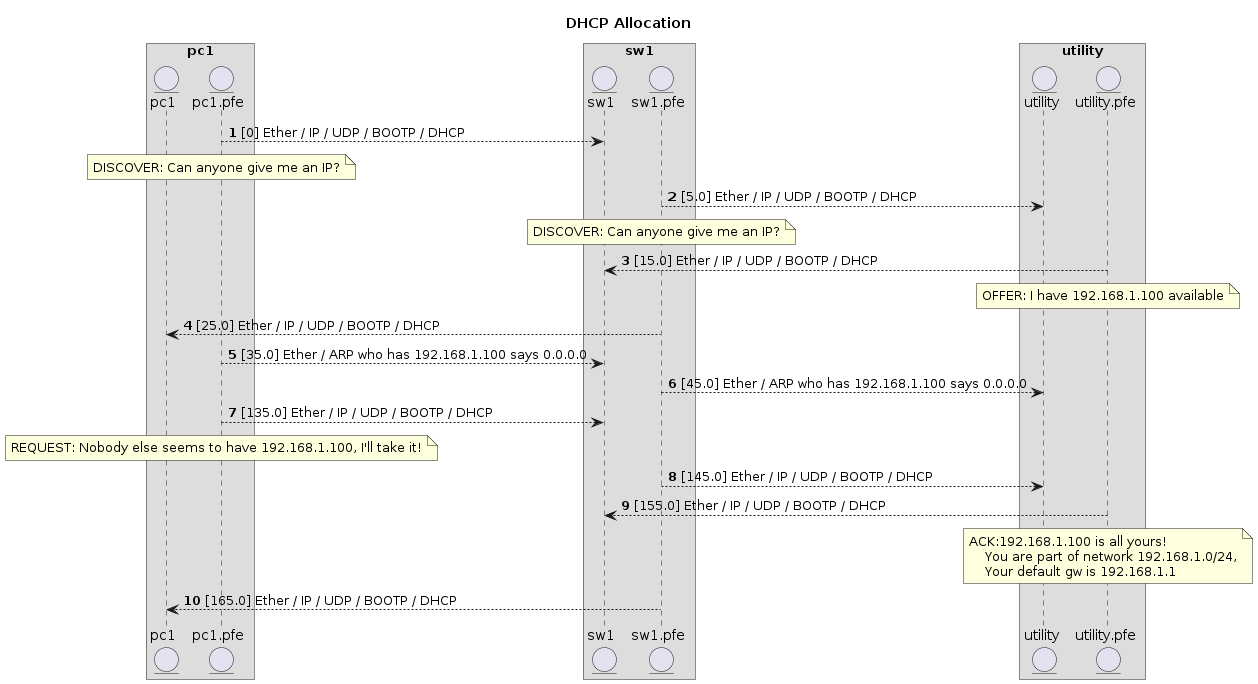

In [6]:

sequence = frame_sequence("DHCP Allocation", [pc1, switch, infra], events)
display(
    Image(
        sequence.png()
    )
)

In [8]:
# let's get pc2 an address as well
pc2.dhcp_client_start()
_ = homenetwork.run_another(500)

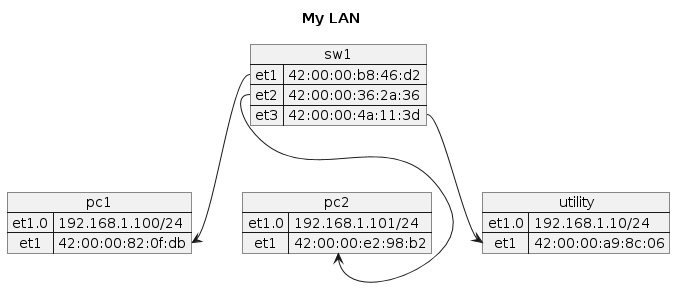

In [9]:
display(
    Image(
topology_diagram(homenetwork.name, homenetwork.get_topology()).png()
    )
)

And just like that, our servers now have addresses and can talk to each other like before.

## A digression into bitmasks

We previously glossed over it in the previous demo, but that "/24" is nearly as important as the IP address itself. It represents the length in bits of the "network" portion of the address. It's also known as the prefix length. Most home
networks will use `192.168.0.0/24` or `192.168.1.0/24` or even `192.168.0.0/16`.

Looking specifically at `192.168.0.0/24` the way to read this is that it creates a *network* of IP addresses that share the first 24 bits (3 octets, a.b.c), with the last octet being able to be allocated to a server. The first address (192.168.0.0) and the last (192.168.0.255) are "reserved" for some low level activity, leaving 254 usable addresses.

Conventionally (but by no means required in any sense), the first address will allocated to the default gateway: 192.168.0.1. This leaves 253 usable addresses for hosts.

The same logic applies to, say, a /22. E.g. `192.168.192.0/22`. In this case the first 22 bits (a.b and 6 bits of the 3rd octet) represent the "network". 

192 = 1100 0000
193 = 1100 0001
194 = 1100 0010
195 = 1100 0011

This provides an additiona 2 bits of "network", such that you get 4 /24s inside it by toggling each of those bits. In total it covers 192.168.192.0 - 192.168.195.255. 